# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import re

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print('Shape of general demographics data: {}'.format(azdias.shape))

Shape of general demographics data: (891221, 85)


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
# create a copy to avoid touching the original df
azdias_cleaned = azdias.copy()


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs

for i, row in enumerate(feat_info.itertuples()):
    
    encoding_list_str = str(row.missing_or_unknown)
    encoding_list_str = re.sub('X', '"X"', encoding_list_str)
    
    encoding_list = eval(encoding_list_str)
    
    replace_pattern = {}
    for encoding in encoding_list:
        replace_pattern[encoding] = np.nan
        
    azdias_cleaned[row.attribute] = azdias_cleaned[row.attribute].replace(to_replace=replace_pattern)
    
    

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# count missing values
missing_values = []
for column in azdias_cleaned.columns:
    missing_values.append(azdias_cleaned[column].isnull().sum())

column_names = list(azdias.columns)


encoding_name_mapping = {encoding:name for encoding, name in enumerate(column_names)}

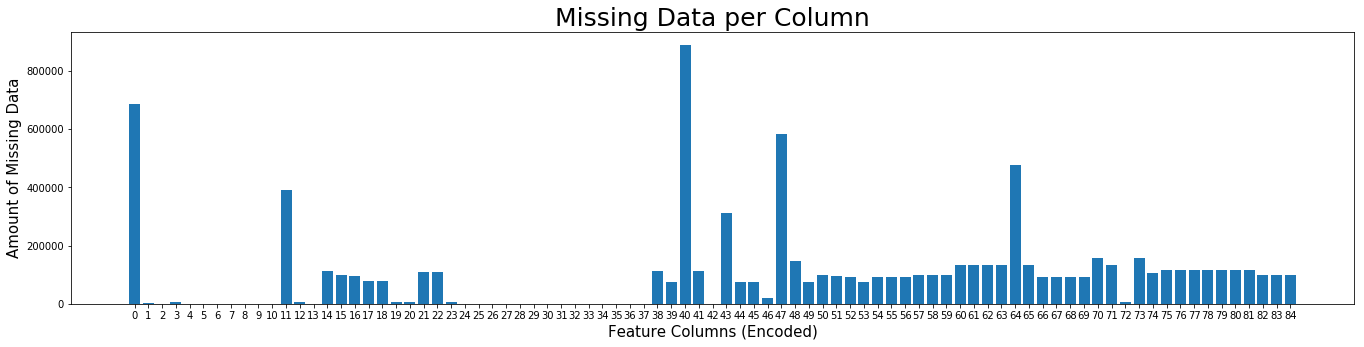

In [9]:
plt.rcParams["figure.figsize"] = (23,5);

plt.bar(range(0, len(missing_values)), missing_values);
plt.xticks(range(0, len(missing_values)));
plt.xlabel('Feature Columns (Encoded)', fontsize=15);
plt.ylabel('Amount of Missing Data', fontsize=15);
plt.title('Missing Data per Column', fontsize=25);
plt.show();

In [10]:
# print mapping of encoding and column names to identify columns with high amounts of missing data
from pprint import pprint
pprint(encoding_name_mapping)

{0: 'AGER_TYP',
 1: 'ALTERSKATEGORIE_GROB',
 2: 'ANREDE_KZ',
 3: 'CJT_GESAMTTYP',
 4: 'FINANZ_MINIMALIST',
 5: 'FINANZ_SPARER',
 6: 'FINANZ_VORSORGER',
 7: 'FINANZ_ANLEGER',
 8: 'FINANZ_UNAUFFAELLIGER',
 9: 'FINANZ_HAUSBAUER',
 10: 'FINANZTYP',
 11: 'GEBURTSJAHR',
 12: 'GFK_URLAUBERTYP',
 13: 'GREEN_AVANTGARDE',
 14: 'HEALTH_TYP',
 15: 'LP_LEBENSPHASE_FEIN',
 16: 'LP_LEBENSPHASE_GROB',
 17: 'LP_FAMILIE_FEIN',
 18: 'LP_FAMILIE_GROB',
 19: 'LP_STATUS_FEIN',
 20: 'LP_STATUS_GROB',
 21: 'NATIONALITAET_KZ',
 22: 'PRAEGENDE_JUGENDJAHRE',
 23: 'RETOURTYP_BK_S',
 24: 'SEMIO_SOZ',
 25: 'SEMIO_FAM',
 26: 'SEMIO_REL',
 27: 'SEMIO_MAT',
 28: 'SEMIO_VERT',
 29: 'SEMIO_LUST',
 30: 'SEMIO_ERL',
 31: 'SEMIO_KULT',
 32: 'SEMIO_RAT',
 33: 'SEMIO_KRIT',
 34: 'SEMIO_DOM',
 35: 'SEMIO_KAEM',
 36: 'SEMIO_PFLICHT',
 37: 'SEMIO_TRADV',
 38: 'SHOPPER_TYP',
 39: 'SOHO_KZ',
 40: 'TITEL_KZ',
 41: 'VERS_TYP',
 42: 'ZABEOTYP',
 43: 'ALTER_HH',
 44: 'ANZ_PERSONEN',
 45: 'ANZ_TITEL',
 46: 'HH_EINKOMMEN_SCORE',
 47: '

In [11]:
# identifying outlier columns by calculating standard deviations (just to confirm the bar chart)
missing_values_outliers = []
column_names_outliers = []
for v, c in zip(missing_values, column_names):
    if v > np.mean(missing_values) + np.std(missing_values):
        missing_values_outliers.append(v)
        column_names_outliers.append(c)

In [12]:
for n, v in zip(column_names_outliers, missing_values_outliers):
    print('Column: {}; Missing Values: {}'.format(n, v))

Column: AGER_TYP; Missing Values: 685843
Column: GEBURTSJAHR; Missing Values: 392318
Column: TITEL_KZ; Missing Values: 889061
Column: ALTER_HH; Missing Values: 310267
Column: KK_KUNDENTYP; Missing Values: 584612
Column: KBA05_BAUMAX; Missing Values: 476524


In [13]:
# Investigate patterns in the amount of missing data in each column.

# Print columns containing no missing values
for v, c in zip(missing_values, column_names):
    if v == 0:
        print('Column: {}; Missing Values: {}'.format(c,v))

Column: ANREDE_KZ; Missing Values: 0
Column: FINANZ_MINIMALIST; Missing Values: 0
Column: FINANZ_SPARER; Missing Values: 0
Column: FINANZ_VORSORGER; Missing Values: 0
Column: FINANZ_ANLEGER; Missing Values: 0
Column: FINANZ_UNAUFFAELLIGER; Missing Values: 0
Column: FINANZ_HAUSBAUER; Missing Values: 0
Column: FINANZTYP; Missing Values: 0
Column: GREEN_AVANTGARDE; Missing Values: 0
Column: SEMIO_SOZ; Missing Values: 0
Column: SEMIO_FAM; Missing Values: 0
Column: SEMIO_REL; Missing Values: 0
Column: SEMIO_MAT; Missing Values: 0
Column: SEMIO_VERT; Missing Values: 0
Column: SEMIO_LUST; Missing Values: 0
Column: SEMIO_ERL; Missing Values: 0
Column: SEMIO_KULT; Missing Values: 0
Column: SEMIO_RAT; Missing Values: 0
Column: SEMIO_KRIT; Missing Values: 0
Column: SEMIO_DOM; Missing Values: 0
Column: SEMIO_KAEM; Missing Values: 0
Column: SEMIO_PFLICHT; Missing Values: 0
Column: SEMIO_TRADV; Missing Values: 0
Column: ZABEOTYP; Missing Values: 0


In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
print('Azdias df total shape: {}'.format(azdias_cleaned.shape))

azdias_cleaned = azdias_cleaned.drop(labels=column_names_outliers, axis=1)
print('Azdias df shape without outlier columns: {}'.format(azdias_cleaned.shape))

Azdias df total shape: (891221, 85)
Azdias df shape without outlier columns: (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

I identified the columns with especially high amounts of missing data using two approaches. At first I plotted the amount of missing data per column using a bar chart. I found that more intuitive than using a histogram. I identified the following columns as lacking especially high amounts of data: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', and 'KBA05_BAUMAX'. To confirm this I calculated standard deviations for the missing data per column. All identified columns deviate severely from the mean of missing data. The named columns were removed from the dataset.

Moreover, it is noteworthy that the columns containing information about the financial typology (FINANZ_) and the personality typology (SEMIO_) do not miss any data. Most other feature columns show some substantial amount of missing data, although this is still quite reduced compared to the removed outlier columns. 


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
# How much data is missing in each row of the dataset?

#calculate missing values per row
missing_values_per_row = azdias_cleaned.isnull().sum(axis=1).tolist()

In [16]:
print('Mean of missing values (per row): {}'.format(round(np.mean(missing_values_per_row),2)))
print('Standard deviation of missing values (per row): {}'.format(round(np.std(missing_values_per_row),2)))

Mean of missing values (per row): 5.65
Standard deviation of missing values (per row): 13.23


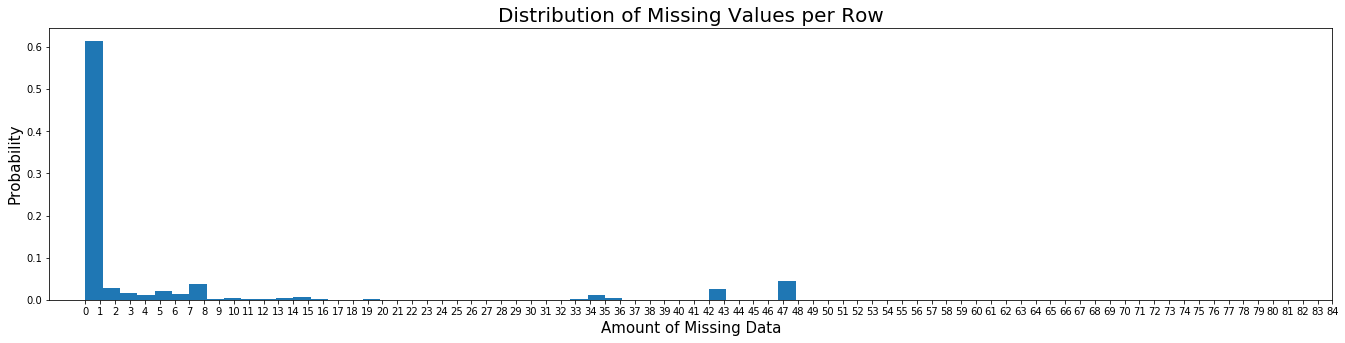

In [17]:
plt.hist(missing_values_per_row, bins=int(len(missing_values)/2), density=True);
plt.xticks(range(0, len(missing_values)));
plt.title('Distribution of Missing Values per Row', fontsize=20);
plt.ylabel('Probability', fontsize=15);
plt.xlabel('Amount of Missing Data', fontsize=15);
plt.show()

In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = int(np.mean(missing_values_per_row))

missing_values_per_row = np.array(missing_values_per_row)
azdias_cleaned_high = azdias_cleaned[missing_values_per_row >= threshold]
azdias_cleaned_low = azdias_cleaned[missing_values_per_row < threshold]

print('Shape of general demographics data with few missing data: {}'.format(azdias_cleaned_low.shape))
print('Shape of general demographics data with much missing data: {}'.format(azdias_cleaned_high.shape))

Shape of general demographics data with few missing data: (697109, 79)
Shape of general demographics data with much missing data: (194112, 79)


In [19]:
def create_countplots(dataset_1, dataset_2, column_name):
    '''
    '''
    fig, ax = plt.subplots(1,2)
    ax[0].set_title('Data with few missing data')
    ax[1].set_title('Data with much missing data')
    sns.countplot(dataset_1[column_name], ax=ax[0])
    sns.countplot(dataset_2[column_name], ax=ax[1])

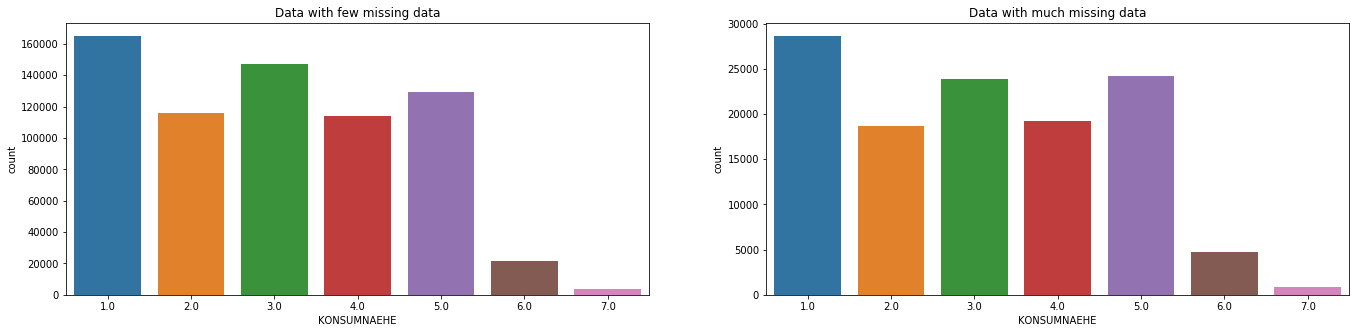

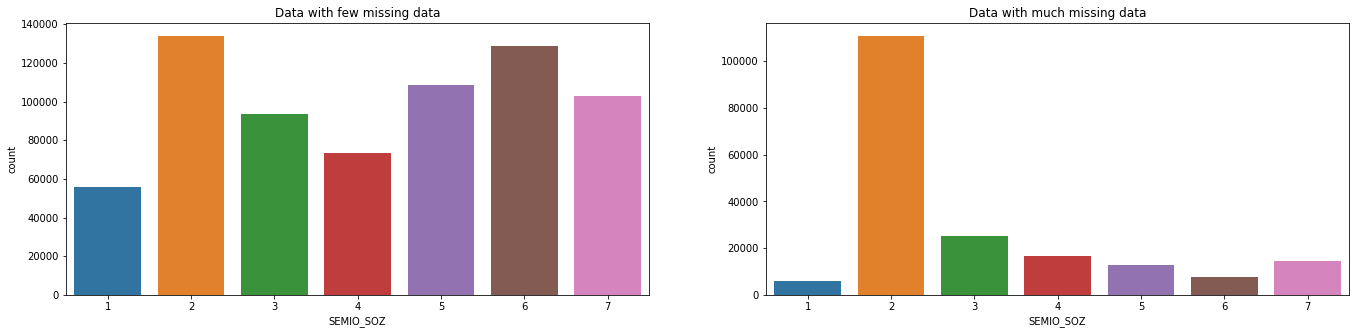

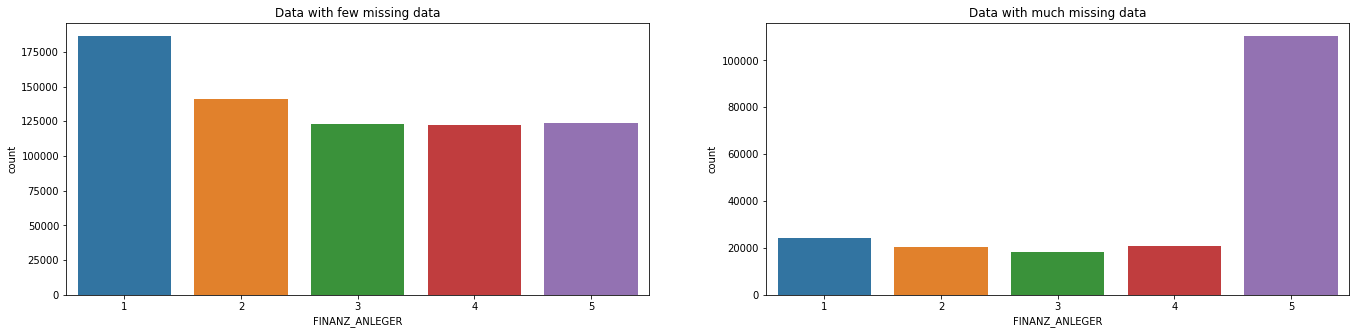

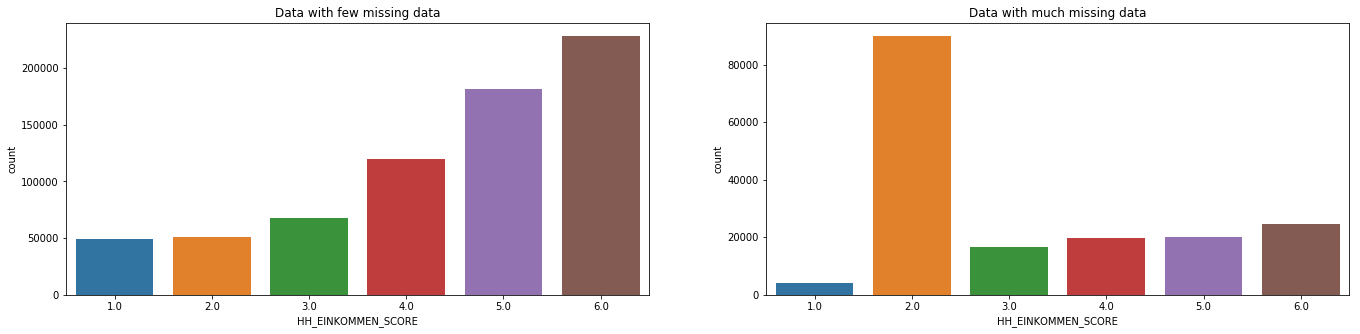

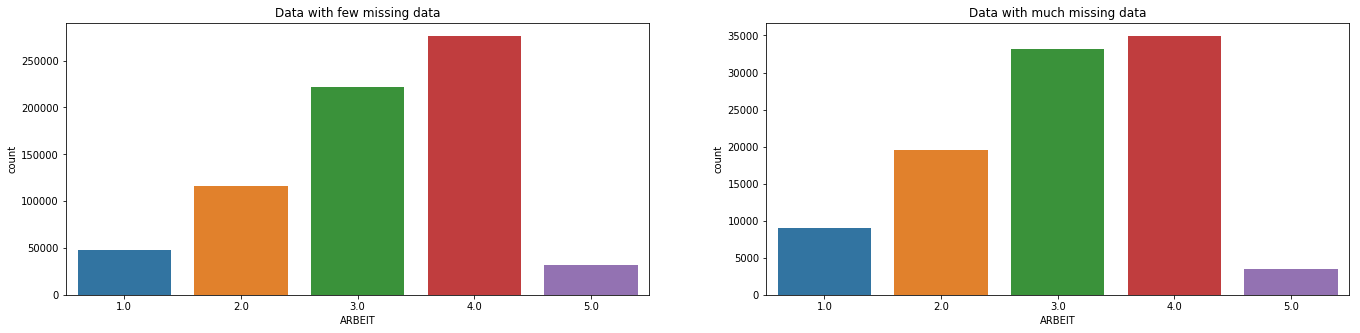

In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
columns_to_be_checked = ['KONSUMNAEHE', 'SEMIO_SOZ', 'FINANZ_ANLEGER', 'HH_EINKOMMEN_SCORE', 'ARBEIT']

for column_name in columns_to_be_checked:
    create_countplots(azdias_cleaned_low, azdias_cleaned_high, column_name)


#### Discussion 1.1.3: Assess Missing Data in Each Row

Calculating mean and standard deviation and plotting the distribution of missing values in a histogram show that most rows have < 5 missing values. I use the mean of the amounts of missing values as the threshold for splitting the dataset into two parts. 

Based on the (relatively) random subset of 5 columns, the counts show differing patterns with respect to the dataset split (low missing value vs much missing value). Some columns show a comparable distribution, while others have large differences. The data columns containing much missing data should be handled individually.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [22]:
azdias_re_encoded_low = azdias_cleaned_low.copy()

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
categorical_columns = feat_info[feat_info['type'] == 'categorical']['attribute']
categorical_columns = [c for c in categorical_columns if c in azdias_re_encoded_low.columns]
azdias_re_encoded_low_categorical = azdias_re_encoded_low[categorical_columns]

In [24]:
# categorical multi class columns 
# decisions have been made with respect to Data_Dictionary.md
categorical_to_keep = ['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'SHOPPER_TYP', 'CAMEO_DEUG_2015']
categorical_to_drop = ['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEU_2015']

for categorical_column in categorical_columns:
    # categorical binary non-numerical
    if len(azdias_re_encoded_low_categorical[categorical_column].value_counts()) == 2:
        if azdias_re_encoded_low_categorical[categorical_column].value_counts().index.dtype == 'O':
            azdias_re_encoded_low.loc[azdias_re_encoded_low['OST_WEST_KZ'] == 'W', 'OST_WEST_KZ'] = 0
            azdias_re_encoded_low.loc[azdias_re_encoded_low['OST_WEST_KZ'] == 'O', 'OST_WEST_KZ'] = 1
    # categorical multi non-numerical
    elif len(azdias_re_encoded_low_categorical[categorical_column].value_counts()) > 2:
        # categories to keep 
        if categorical_column in categorical_to_keep:
            dummy_df = pd.get_dummies(azdias_re_encoded_low[categorical_column], prefix=categorical_column)
            azdias_re_encoded_low = pd.concat([azdias_re_encoded_low, dummy_df], axis=1)
            azdias_re_encoded_low = azdias_re_encoded_low.drop(columns=[categorical_column])
        # categories to drop
        if categorical_column in categorical_to_drop:
            azdias_re_encoded_low = azdias_re_encoded_low.drop(columns=[categorical_column])

#### Discussion 1.2.1: Re-Encode Categorical Features

I consulted Data_Dictionary.md in order to separate important categorical columns from the ones to be dropped. I decided on keeping the columns most relevant for analysing the cusomters' buying behavior. 

Specifically, I decided on keeping all coarse grained columns (i.e. 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015') as the fine grained columns are expected be too detailed for my analysis. I also kept columns refering to a person's wealth and handling of money (i.e. 'CJT_GESAMTTYP', 'FINANZTYP', 'SHOPPER_TYP'). All categorical columns with multiple non-numerical classes were removed from the dataset.

Multi class columns were re-encoded using Pandas' .get_dummies method. The binary non-numerical column (i.e. 'OST_WEST_KZ') was simply re-encoded in place. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [25]:
mixed_columns = feat_info[feat_info['type'] == 'mixed']['attribute']
mixed_columns = [c for c in mixed_columns if c in azdias_re_encoded_low.columns]
print(mixed_columns)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
youth_decade_mapping = {
    -1 : 0, # unknown
    0 : 0, # unknown
    1 : 1, # 40s
    2 : 1, # 40s
    3 : 2, # 50s
    4 : 2, # 50s
    5 : 3, # 60s 
    6 : 3, # 60s
    7 : 3, # 60s
    8 : 4, # 70s
    9 : 4, # 70s
    10 : 5, # 80s
    11 : 5, # 80s
    12 : 5, # 80s
    13 : 5, # 80s
    14 : 6, # 90s
    15 : 6 # 90s
}

azdias_re_encoded_low['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_re_encoded_low['PRAEGENDE_JUGENDJAHRE'].map(youth_decade_mapping)

youth_movement_mapping = {
    -1 : 0, # unknown
    0 : 0, # unknown
    1 : 1, # mainstream
    2 : 2, # avantgarde
    3 : 1, # mainstream
    4 : 2, # avantgarde
    5 : 1, # mainstream
    6 : 2, # avantgarde
    7 : 2, # avantgarde
    8 : 1, # mainstream
    9 : 2, # avantgarde
    10 : 1, # mainstream
    11 : 2, # avantgarde
    12 : 1, # mainstream
    13 : 2, # avantgarde
    14 : 1, # mainstream
    15 : 2 # avantgarde
}

azdias_re_encoded_low['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_re_encoded_low['PRAEGENDE_JUGENDJAHRE'].map(youth_movement_mapping)


In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

wealth_mapping = {
    -1 : 0, # unknown
    11 : 1, # wealthy
    12 : 1, # wealthy
    13 : 1, # wealthy
    15 : 1, # wealthy
    21 : 2, # prosperous
    22 : 2, # prosperous
    23 : 2, # prosperous
    24 : 2, # prosperous
    25 : 2, # prosperous
    31 : 3, # comfortable
    32 : 3, # comfortable
    33 : 3, # comfortable
    34 : 3, # comfortable
    35 : 3, # comfortable
    41 : 4, # less affluent
    42 : 4, # less affluent 
    43 : 4, # less affluent 
    44 : 4, # less affluent
    45 : 4, # less affluent
    51 : 5, # poorer 
    52 : 5, # poorer 
    53 : 5, # poorer 
    54 : 5, # poorer 
    55 : 5, # poorer 
    'XX' : 0 # unknown
}

azdias_re_encoded_low['CAMEO_INTL_2015_WEALTH'] = azdias_re_encoded_low['CAMEO_INTL_2015'].map(wealth_mapping)


life_stage_mapping = {
    -1 : 0, # unknown
    11 : 1, # Pre-Family Couples & Singles
    12 : 2, # Young Couples With Children
    13 : 3, # Families With School Age Children
    14 : 4, # Older Families &  Mature Couples
    15 : 5, # Elders In Retirement
    21 : 1, # Pre-Family Couples & Singles
    22 : 2, # Young Couples With Children
    23 : 3, # Families With School Age Children
    24 : 4, # Older Families &  Mature Couples
    25 : 5, # Elders In Retirement
    31 : 1, # Pre-Family Couples & Singles
    32 : 2, # Young Couples With Children
    33 : 3, # Families With School Age Children
    34 : 4, # Older Families &  Mature Couples
    35 : 5, # Elders In Retirement
    41 : 1, # Pre-Family Couples & Singles
    42 : 2, # Young Couples With Children
    43 : 3, # Families With School Age Children
    44 : 4, # Older Families &  Mature Couples
    45 : 5, # Elders In Retirement
    51 : 1, # Pre-Family Couples & Singles
    52 : 2, # Young Couples With Children
    53 : 3, # Families With School Age Children
    54 : 4, # Older Families &  Mature Couples
    55 : 5, # Elders In Retirement
    'XX' : 0 # unknown 
}

azdias_re_encoded_low['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_re_encoded_low['CAMEO_INTL_2015'].map(life_stage_mapping)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I separated the information given in 'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE' using a simple mapping containing the respective classes and new encodings. Afterwards, the mixed-type columns were dropped.

I also decided against using the other mixed-type columns as no new important information could be gathered from these. 'LP_LEBENSPHASE_FEIN' and 'LP_LEBENSPHASE_GROB' contained information about life stages, which were already contained in 'CAMEO_INTL_2015'. 'PLZ8_BAUMAX' does contain information that I consider unlikely to help solving this task. 

I decided on keeping 'WOHNLAGE' as this variable is probably linked to income and could help clustering the dataset. However I did not consider it necessary to split the column into more feature types. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [28]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [29]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

mixed_columns_to_drop = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']

azdias_re_encoded_low = azdias_re_encoded_low.drop(columns=mixed_columns_to_drop)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [95]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_copy = df.copy()
    print('DF shape: {}'.format(df_copy.shape))
    
    for i, row in enumerate(feat_info.itertuples()):
    
        encoding_list_str = str(row.missing_or_unknown)
        encoding_list_str = re.sub('X', '"X"', encoding_list_str)
    
        encoding_list = eval(encoding_list_str)
    
        replace_pattern = {}
        for encoding in encoding_list:
            replace_pattern[encoding] = np.nan
        
        df_copy[row.attribute] = df_copy[row.attribute].replace(to_replace=replace_pattern)
    
    # remove selected columns and rows, ...
    
    # columns
    missing_values = []
    for column in df_copy.columns:
        missing_values.append(df_copy[column].isnull().sum())

    column_names = list(df_copy.columns)

    missing_values_outliers = []
    column_names_outliers = []
    for v, c in zip(missing_values, column_names):
        if v > np.mean(missing_values) + np.std(missing_values):
            missing_values_outliers.append(v)
            column_names_outliers.append(c)
    print('Outlier columns:')
    for n, v in zip(column_names_outliers, missing_values_outliers):
        print('Column: {}; Missing Values: {}'.format(n, v))
    
    df_copy = df_copy.drop(labels=column_names_outliers, axis=1)
    print('DF shape without outlier columns: {}'.format(df_copy.shape))
    
    # rows
    missing_values_per_row = df_copy.isnull().sum(axis=1).tolist()
    
    threshold = int(np.mean(missing_values_per_row))

    missing_values_per_row = np.array(missing_values_per_row)
    df_copy_high = df_copy[missing_values_per_row >= threshold]
    df_copy_low = df_copy[missing_values_per_row < threshold] # kept for further processing
    print('DF shape without outlier rows: {}'.format(df_copy_low.shape))
    
    # select, re-encode, and engineer column values.
    
    # categorical
    categorical_columns = feat_info[feat_info['type'] == 'categorical']['attribute']
    categorical_columns = [c for c in categorical_columns if c in df_copy_low.columns]
    df_copy_low_categorical = df_copy_low[categorical_columns]
    
    categorical_to_keep = ['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'SHOPPER_TYP', 'CAMEO_DEUG_2015']
    categorical_to_drop = ['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEU_2015']

    for categorical_column in categorical_columns:
        # categorical binary non-numerical
        if len(df_copy_low_categorical[categorical_column].value_counts()) == 2:
            if df_copy_low_categorical[categorical_column].value_counts().index.dtype == 'O':
                df_copy_low.loc[df_copy_low['OST_WEST_KZ'] == 'W', 'OST_WEST_KZ'] = 0
                df_copy_low.loc[df_copy_low['OST_WEST_KZ'] == 'O', 'OST_WEST_KZ'] = 1
        # categorical multi non-numerical
        elif len(df_copy_low_categorical[categorical_column].value_counts()) > 2:
            # categories to keep 
            if categorical_column in categorical_to_keep:
                dummy_df = pd.get_dummies(df_copy_low[categorical_column], prefix=categorical_column)
                df_copy_low = pd.concat([df_copy_low, dummy_df], axis=1)
                df_copy_low = df_copy_low.drop(columns=[categorical_column])
            # categories to drop
            if categorical_column in categorical_to_drop:
                df_copy_low = df_copy_low.drop(columns=[categorical_column])
    
    # mixed
    youth_decade_mapping = {
        -1 : 0, # unknown
        0 : 0, # unknown
        1 : 1, # 40s
        2 : 1, # 40s
        3 : 2, # 50s
        4 : 2, # 50s
        5 : 3, # 60s 
        6 : 3, # 60s
        7 : 3, # 60s
        8 : 4, # 70s
        9 : 4, # 70s
        10 : 5, # 80s
        11 : 5, # 80s
        12 : 5, # 80s
        13 : 5, # 80s
        14 : 6, # 90s
        15 : 6 # 90s
    }

    df_copy_low['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_copy_low['PRAEGENDE_JUGENDJAHRE'].map(youth_decade_mapping)

    youth_movement_mapping = {
        -1 : 0, # unknown
        0 : 0, # unknown
        1 : 1, # mainstream
        2 : 2, # avantgarde
        3 : 1, # mainstream
        4 : 2, # avantgarde
        5 : 1, # mainstream
        6 : 2, # avantgarde
        7 : 2, # avantgarde
        8 : 1, # mainstream
        9 : 2, # avantgarde
        10 : 1, # mainstream
        11 : 2, # avantgarde
        12 : 1, # mainstream
        13 : 2, # avantgarde
        14 : 1, # mainstream
        15 : 2 # avantgarde
    }

    df_copy_low['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_copy_low['PRAEGENDE_JUGENDJAHRE'].map(youth_movement_mapping)
    
   
    wealth_mapping = {
        -1 : 0, # unknown
        11 : 1, # wealthy
        12 : 1, # wealthy
        13 : 1, # wealthy
        15 : 1, # wealthy
        21 : 2, # prosperous
        22 : 2, # prosperous
        23 : 2, # prosperous
        24 : 2, # prosperous
        25 : 2, # prosperous
        31 : 3, # comfortable
        32 : 3, # comfortable
        33 : 3, # comfortable
        34 : 3, # comfortable
        35 : 3, # comfortable
        41 : 4, # less affluent
        42 : 4, # less affluent 
        43 : 4, # less affluent 
        44 : 4, # less affluent
        45 : 4, # less affluent
        51 : 5, # poorer 
        52 : 5, # poorer 
        53 : 5, # poorer 
        54 : 5, # poorer 
        55 : 5, # poorer 
        'XX' : 0 # unknown
    }

    df_copy_low['CAMEO_INTL_2015_WEALTH'] = df_copy_low['CAMEO_INTL_2015'].map(wealth_mapping)

    life_stage_mapping = {
        -1 : 0, # unknown
        11 : 1, # Pre-Family Couples & Singles
        12 : 2, # Young Couples With Children
        13 : 3, # Families With School Age Children
        14 : 4, # Older Families &  Mature Couples
        15 : 5, # Elders In Retirement
        21 : 1, # Pre-Family Couples & Singles
        22 : 2, # Young Couples With Children
        23 : 3, # Families With School Age Children
        24 : 4, # Older Families &  Mature Couples
        25 : 5, # Elders In Retirement
        31 : 1, # Pre-Family Couples & Singles
        32 : 2, # Young Couples With Children
        33 : 3, # Families With School Age Children
        34 : 4, # Older Families &  Mature Couples
        35 : 5, # Elders In Retirement
        41 : 1, # Pre-Family Couples & Singles
        42 : 2, # Young Couples With Children
        43 : 3, # Families With School Age Children
        44 : 4, # Older Families &  Mature Couples
        45 : 5, # Elders In Retirement
        51 : 1, # Pre-Family Couples & Singles
        52 : 2, # Young Couples With Children
        53 : 3, # Families With School Age Children
        54 : 4, # Older Families &  Mature Couples
        55 : 5, # Elders In Retirement
        'XX' : 0 # unknown 
    }

    df_copy_low['CAMEO_INTL_2015_LIFE_STAGE'] = df_copy_low['CAMEO_INTL_2015'].map(life_stage_mapping)
    
    
    mixed_columns_to_drop = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']

    df_copy_low = df_copy_low.drop(columns=mixed_columns_to_drop)
    
    
    # Return the cleaned dataframe.
    return df_copy_low, df_copy_high
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [31]:
azdias_scaled = azdias_re_encoded_low.copy()

In [32]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer(axis=1, strategy='most_frequent')
azdias_scaled = imputer.fit_transform(azdias_scaled)

In [33]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_scaled)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I decided on imputing the most frequent value of a column for missing values in the data frame as most columns have a substantial amount of missing data. Using the mean or median would not make sense as many columns contain categorical data. 

For scaling, I used the StandardScaler, which scales the data to mean of 0 and standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [34]:
# Apply PCA to the data.
pca_explorative = PCA()
pca_azdias_explorative = pca_explorative.fit_transform(azdias_scaled)


In [35]:
print('AZDIAS dimensions: {}'.format(azdias_scaled.shape))
print('PCA dimensions: {}'.format(pca_azdias_explorative.shape))

AZDIAS dimensions: (697109, 100)
PCA dimensions: (697109, 100)


In [36]:
# Investigate the variance accounted for by each principal component.
ratios = pca_explorative.explained_variance_ratio_
cum_ratios = np.cumsum(ratios)
ind = np.arange(pca_azdias_explorative.shape[1])

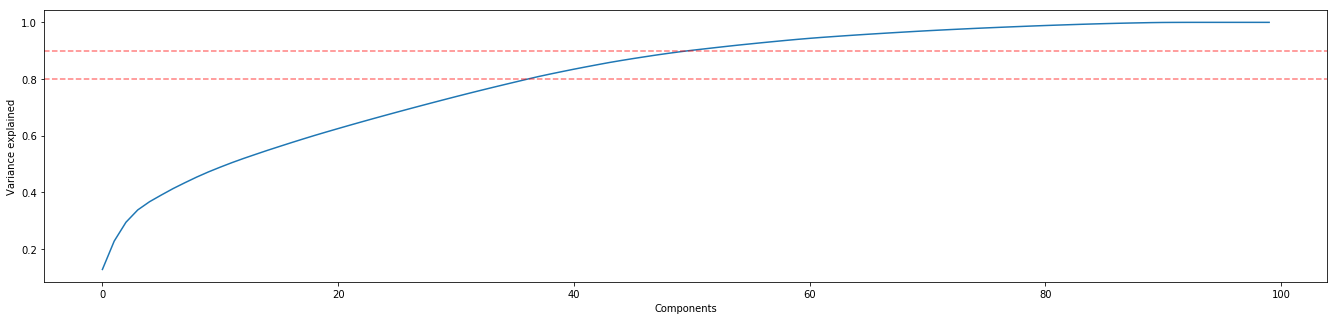

In [37]:
# Plot variance 
plt.plot(ind, cum_ratios);
plt.axhline(0.8, color='r', alpha=0.5, linestyle='--');
plt.axhline(0.9, color='r', alpha=0.5, linestyle='--');
plt.xlabel('Components');
plt.ylabel('Variance explained');
plt.show();

In [38]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=50)
pca_azdias = pca.fit_transform(azdias_scaled)


### Discussion 2.2: Perform Dimensionality Reduction

I performed PCA using the whole dataset and plotted the cumulative variance ratios. The plot shows that using 40 PCA components already covers more than 80% of variance in the data. Using 50 components covers about 90% of variance. For the clustering approach I performed PCA again using 50 components. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [39]:
def print_component_weights(pca, comp_n, feature_names):
    if comp_n <= len(pca.components_):
        component_weights = pd.DataFrame({'weights': pca.components_[comp_n]}, index=feature_names)
        
        print('Most weighted features for component: {} '.format(comp_n))
        print(component_weights.sort_values(by=['weights']).head(5))
        print(component_weights.sort_values(by=['weights']).tail(5))

In [40]:
azdias_scaled_columns = pd.DataFrame(azdias_re_encoded_low).columns

In [41]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
print_component_weights(pca, 0, azdias_scaled_columns)


Most weighted features for component: 0 
                    weights
MOBI_REGIO        -0.223625
FINANZ_MINIMALIST -0.216891
KBA05_ANTG1       -0.208378
PLZ8_ANTG1        -0.201333
KBA05_GBZ         -0.200497
                     weights
ORTSGR_KLS9         0.176767
HH_EINKOMMEN_SCORE  0.191483
PLZ8_ANTG4          0.195450
PLZ8_ANTG3          0.202611
LP_STATUS_GROB_1.0  0.210151


In [42]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_component_weights(pca, 1, azdias_scaled_columns)


Most weighted features for component: 1 
                               weights
PRAEGENDE_JUGENDJAHRE_DECADE -0.240411
SEMIO_REL                    -0.232773
FINANZ_SPARER                -0.223126
FINANZ_UNAUFFAELLIGER        -0.217610
SEMIO_PFLICHT                -0.211653
                       weights
RETOURTYP_BK_S        0.160765
SEMIO_LUST            0.168044
SEMIO_ERL             0.204734
FINANZ_VORSORGER      0.218433
ALTERSKATEGORIE_GROB  0.235362


In [43]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_component_weights(pca, 2, azdias_scaled_columns)


Most weighted features for component: 2 
             weights
ANREDE_KZ  -0.356453
SEMIO_KAEM -0.327019
SEMIO_DOM  -0.298577
SEMIO_KRIT -0.263971
SEMIO_RAT  -0.188112
              weights
FINANZTYP_5  0.144519
SEMIO_KULT   0.238879
SEMIO_FAM    0.254868
SEMIO_SOZ    0.259989
SEMIO_VERT   0.332581


### Discussion 2.3: Interpret Principal Components

It seems possible to interpret the first principal components:

1. The first component seems to focus on finances and living conditions which are of course interrelated. Negative weights are focusing on features dealing with better situated people (e.g. rate of building housing only a few families). Positive values are focusing on features dealing with less well situated people (e.g. rate of buildings housing many families, low income status). 

2. The second component is more focusing on personality. Negative weights seem to circle around 'reliable' traits (e.g. dutiful) and conservative purchase behavior (e.g. inconspicious and saving behavior). Positive weights circle around more extroverted traits (e.g. event orientation, sensual mind). 

3. The thirs component again focuses around personality. A nice split between negative and positive weights is possible again. Negative values circle around stereotypical masculin traits (e.g. combative, dominant, critical, rational). Positive weights circle around stereotypical feminin traits (e.g. cultural-minded, family-minded, social, dreamful).  

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [44]:
# Over a number of different cluster counts...
cluster_n = list(range(10,31))
dist_scores = []
for n in cluster_n:
    print('Train k-means for k = {}'.format(n))
    # run k-means clustering on the data and...
    k_means = KMeans(n_clusters=n).fit(pca_azdias)
    
    # compute the average within-cluster distances.
    #dist_scores.append(abs(k_means.score(pca_azdias)))
    dist_scores.append(k_means.inertia_)

Train k-means for k = 10
Train k-means for k = 11
Train k-means for k = 12
Train k-means for k = 13
Train k-means for k = 14
Train k-means for k = 15
Train k-means for k = 16
Train k-means for k = 17
Train k-means for k = 18
Train k-means for k = 19
Train k-means for k = 20
Train k-means for k = 21
Train k-means for k = 22
Train k-means for k = 23
Train k-means for k = 24
Train k-means for k = 25
Train k-means for k = 26
Train k-means for k = 27
Train k-means for k = 28
Train k-means for k = 29
Train k-means for k = 30


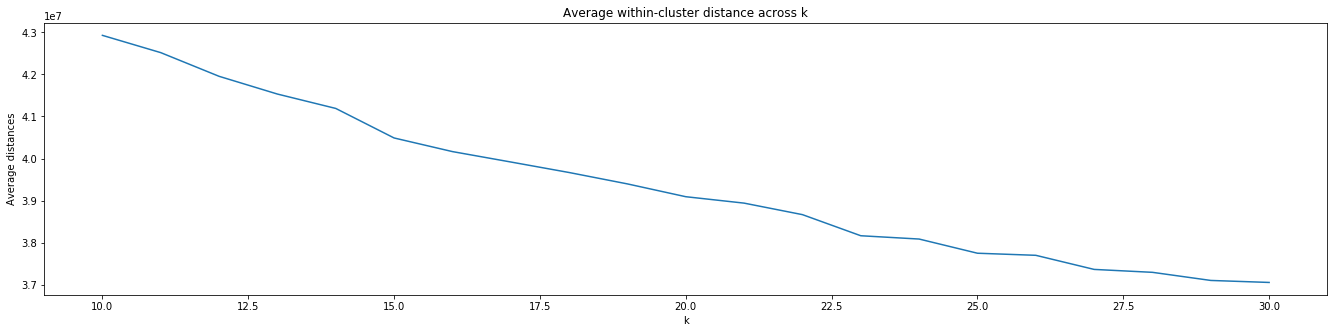

In [45]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster_n, dist_scores);
plt.xlabel('k');
plt.ylabel('Average distances');
plt.title('Average within-cluster distance across k');

In [44]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k = 24
k_means = KMeans(n_clusters=k).fit(pca_azdias)
clusters_azdias = k_means.predict(pca_azdias)


### Discussion 3.1: Apply Clustering to General Population

Having considered the plot I decided on clustering the data using a k of 24. Although the plot is not fully shaped like an elbow, you can see some kind of plateau around k of 23-24. After that, increasing k does not improve the clustering substantially. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [96]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers_cleaned = customers.copy()

In [97]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# preprocessing
customers_cleaned, customers_cleaned_high = clean_data(customers_cleaned, feat_info)

DF shape: (191652, 85)
Outlier columns:
Column: AGER_TYP; Missing Values: 96738
Column: GEBURTSJAHR; Missing Values: 93024
Column: TITEL_KZ; Missing Values: 189340
Column: KK_KUNDENTYP; Missing Values: 111937
Column: KBA05_BAUMAX; Missing Values: 109535
DF shape without outlier columns: (191652, 80)
DF shape without outlier rows: (139372, 80)


In [47]:
customers_scaled = customers_cleaned.copy()

In [48]:
# feature transformation

# imputing 
imputer_customers = Imputer(axis=1, strategy='most_frequent')
customers_scaled = imputer.fit_transform(customers_scaled)


# scaling 
scaler_customers = StandardScaler()
customers_scaled = scaler.fit_transform(customers_scaled)

# PCA
pca_c = PCA(n_components=50)
pca_customers = pca.fit_transform(customers_scaled)

In [49]:
# clustering
k_means_customers = KMeans(n_clusters=k).fit(pca_customers)
clusters_customers = k_means.predict(pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [113]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
clusters_azdias_df = pd.DataFrame({'clusters': clusters_azdias})
cluster_counts_azdias = clusters_azdias_df['clusters'].value_counts()
cluster_proportions_azdias = cluster_counts_azdias / clusters_azdias_df.shape[0]
cluster_proportions_azdias = cluster_proportions_azdias.sort_index()

clusters_customers_df = pd.DataFrame({'clusters': clusters_customers})
cluster_counts_customers = clusters_customers_df['clusters'].value_counts()
cluster_proportions_customers = cluster_counts_customers / clusters_customers_df.shape[0]
cluster_proportions_customers = cluster_proportions_customers.sort_index()

cluster_proportions_diff = cluster_proportions_customers - cluster_proportions_azdias

In [115]:
# for comparison with dropped rows
azdias_cleaned_high_cluster = np.ones(azdias_cleaned_high.shape[0], dtype='int32') * -1
clusters_azdias_full = np.concatenate([clusters_azdias, azdias_cleaned_high_cluster])
clusters_azdias_df_full = pd.DataFrame({'clusters': clusters_azdias})
cluster_counts_azdias_full = clusters_azdias_df_full['clusters'].value_counts()
cluster_proportions_azdias_full = cluster_counts_azdias_full / clusters_azdias_df_full.shape[0]
cluster_proportions_azdias_full = cluster_proportions_azdias_full.sort_index()

customers_cleaned_high_cluster = np.ones(customers_cleaned_high.shape[0], dtype='int32') * -1
clusters_customers_full = np.concatenate([clusters_customers, customers_cleaned_high_cluster])
clusters_customers_df_full = pd.DataFrame({'clusters': clusters_customers_full})
cluster_counts_customers_full = clusters_customers_df_full['clusters'].value_counts()
cluster_proportions_customers_full = cluster_counts_customers_full / clusters_customers_df_full.shape[0]
cluster_proportions_customers_full = cluster_proportions_customers_full.sort_index()

cluster_proportions_diff_full = cluster_proportions_customers_full - cluster_proportions_azdias_full

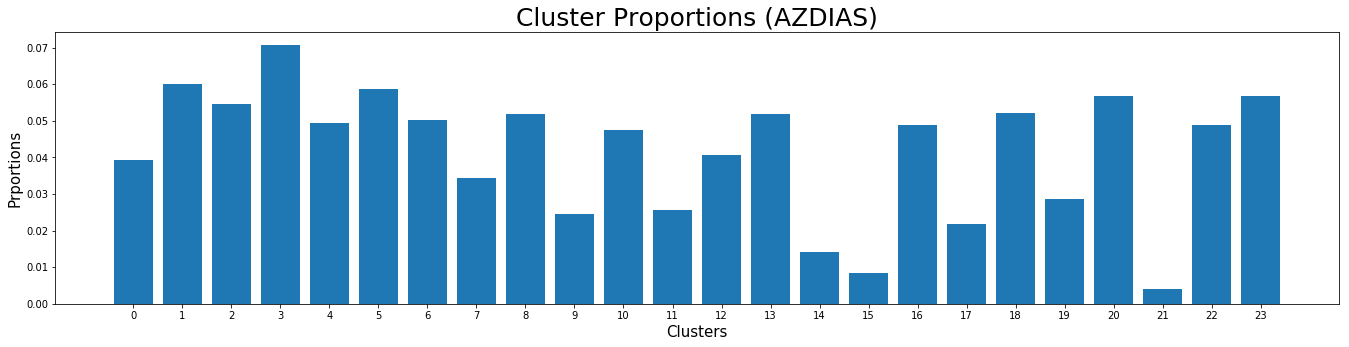

In [76]:
plt.rcParams["figure.figsize"] = (23,5);

plt.bar(range(0, cluster_proportions_azdias.shape[0]), cluster_proportions_azdias);
plt.xticks(range(0, cluster_proportions_azdias.shape[0]));
plt.xlabel('Clusters', fontsize=15);
plt.ylabel('Prportions', fontsize=15);
plt.title('Cluster Proportions (AZDIAS)', fontsize=25);
plt.show();

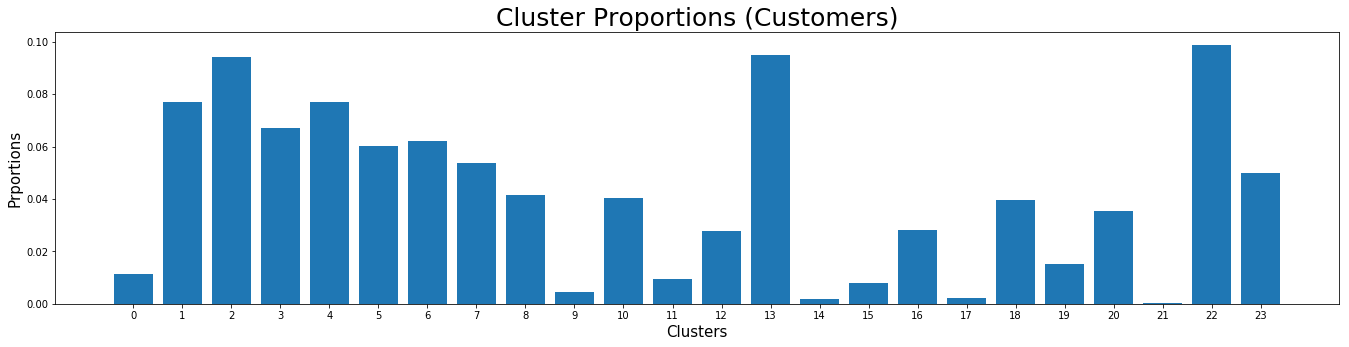

In [77]:
plt.rcParams["figure.figsize"] = (23,5);

plt.bar(range(0, cluster_proportions_customers.shape[0]), cluster_proportions_customers);
plt.xticks(range(0, cluster_proportions_customers.shape[0]));
plt.xlabel('Clusters', fontsize=15);
plt.ylabel('Prportions', fontsize=15);
plt.title('Cluster Proportions (Customers)', fontsize=25);
plt.show();

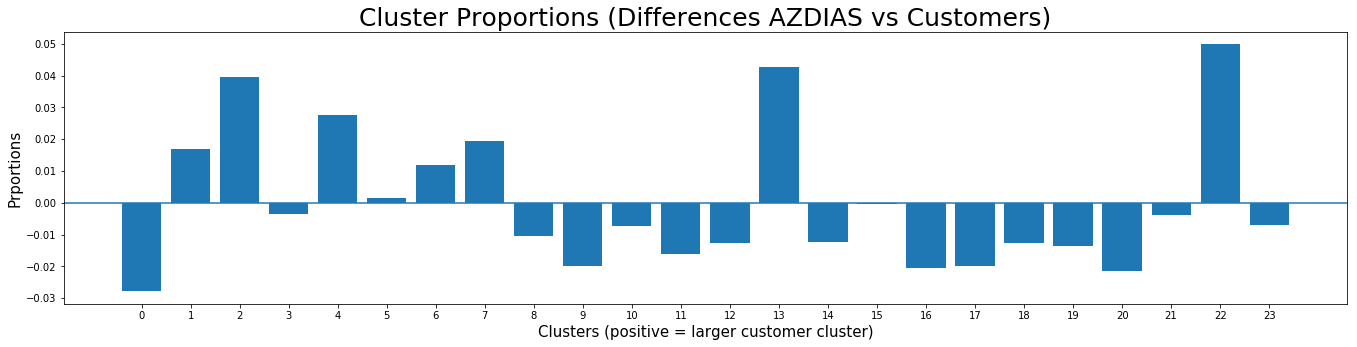

In [87]:
plt.rcParams["figure.figsize"] = (23,5);

plt.bar(range(0, cluster_proportions_diff.shape[0]), cluster_proportions_diff);
plt.axhline(0);
plt.xticks(range(0, cluster_proportions_diff.shape[0]));
plt.xlabel('Clusters (positive = larger customer cluster)', fontsize=15);
plt.ylabel('Prportions', fontsize=15);
plt.title('Cluster Proportions (Differences AZDIAS vs Customers)', fontsize=25);
plt.show();

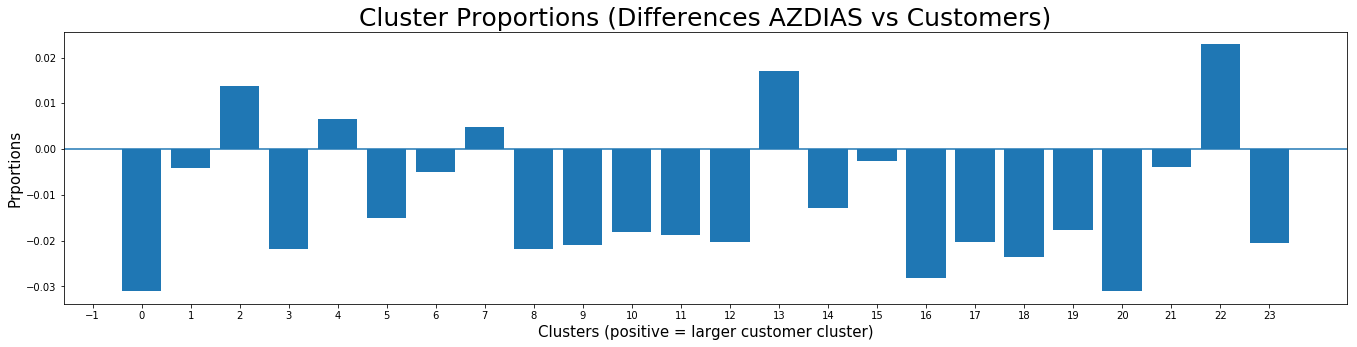

In [120]:
plt.rcParams["figure.figsize"] = (23,5);

plt.bar(range(-1, cluster_proportions_diff_full.shape[0]-1), cluster_proportions_diff_full);
plt.axhline(0);
plt.xticks(range(-1, cluster_proportions_diff_full.shape[0]-1));
plt.xlabel('Clusters (positive = larger customer cluster)', fontsize=15);
plt.ylabel('Prportions', fontsize=15);
plt.title('Cluster Proportions (Differences AZDIAS vs Customers)', fontsize=25);
plt.show();

In [89]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
clusters_ids_over = [1,2,4,5,6,7,13,22]


In [ ]:
#stand_scaler.inverse_transform(pca_model.inverse_transform(model.cluster_centers_[4]))

In [127]:
#scaler_customers.inverse_transform(pca_c.inverse_transform(k_means_customers.cluster_centers_[22]))

AttributeError: 'PCA' object has no attribute 'components_'

In [ ]:
#pca_c.inverse_transform

In [90]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
clusters_ids_under = [0,3,8,9,10,11,12,14,15,16,17,18,19,20,21,23]


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.